In [2]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.io.arff
from scipy import stats

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# carregando o dataset
data, meta = scipy.io.arff.loadarff(f'data/speeddating.arff')
df = pd.DataFrame(data)

# Convertendo byte-strings para strings
str_df = df.select_dtypes([object]).stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]

# ajeitar o tipo dos dados
nominal_cols = [col for col, dtype in zip(meta.names(), meta.types()) if dtype == 'nominal']
for col in nominal_cols:
    df[col] = df[col].astype('category')

df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1,1,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1


In [4]:
df.duplicated().sum()

0

<Axes: xlabel='samerace', ylabel='count'>

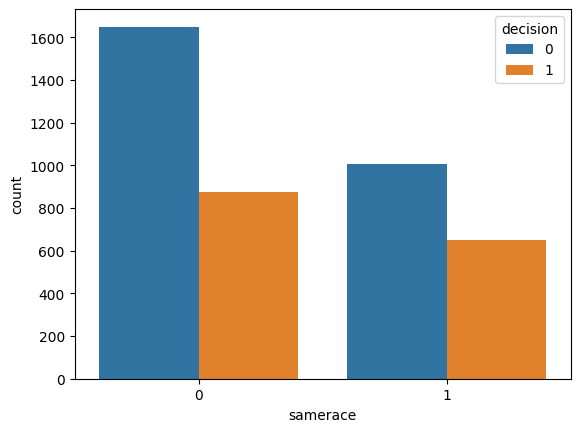

In [5]:
# plot samerace x match

sns.countplot(x='samerace', hue='decision', data=df[df['gender'] == 'female'])

No artigo foi mencionado que mulheres tem preferência por homens da mesma raça que a sua, nesse gráfico percebe-se que em valores absolutos há mais aceitação por homens de raças distintas, ao mesmo tempo que há mais rejeição. Logo, percentualmente falando, há chance de ser aceito por mulheres quando se tem a mesma raça que ela é maior.

<Axes: xlabel='expected_num_interested_in_me', ylabel='count'>

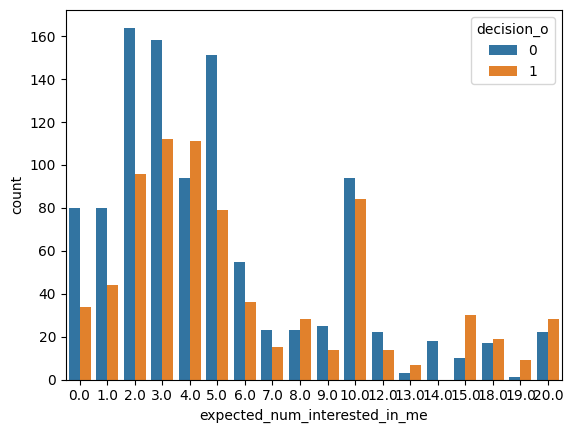

In [6]:
# plot expected_num_interested_in_me x match

sns.countplot(x='expected_num_interested_in_me', hue='decision_o', data=df)

Este gráfico ilustra a relação entre a autoconfiança do participante (baseada na quantidade de pessoas que ele acredita estar interessadas nele) e a decisão de aceitação ou rejeição por parte de outra pessoa. Em outras palavras, ele explora como a percepção do participante sobre seu próprio "atrativo social" se correlaciona com o resultado real de um interesse romântico ou interpessoal. É notório que, quanto mais autoconfiança menor é a chance de ser rejeitado, salvo a exceção da expectativa de ter 14 pessoas interessadas, que resultou apenas em rejeições.

c:\Users\caiop\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


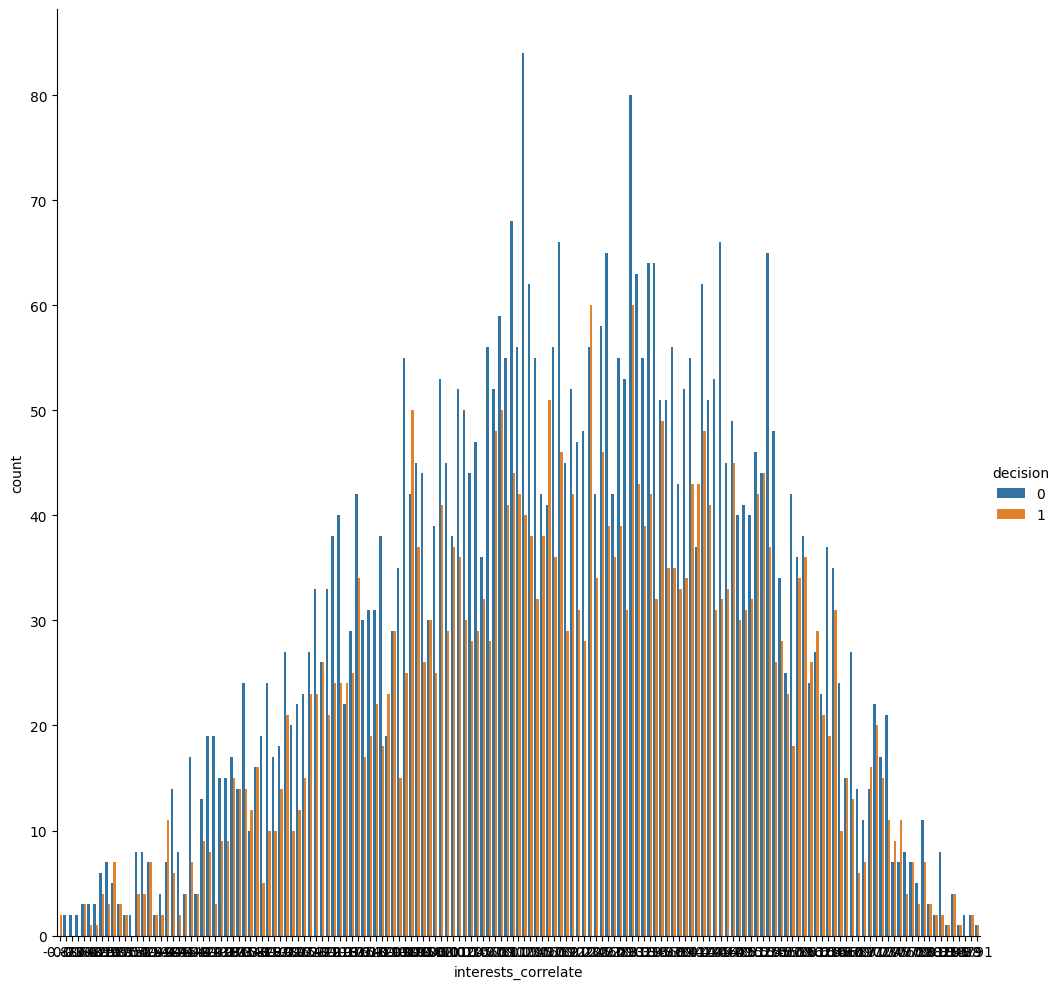

In [7]:
sns.catplot(x='interests_correlate', hue='decision', data=df, kind='count', height=10)

c:\Users\caiop\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


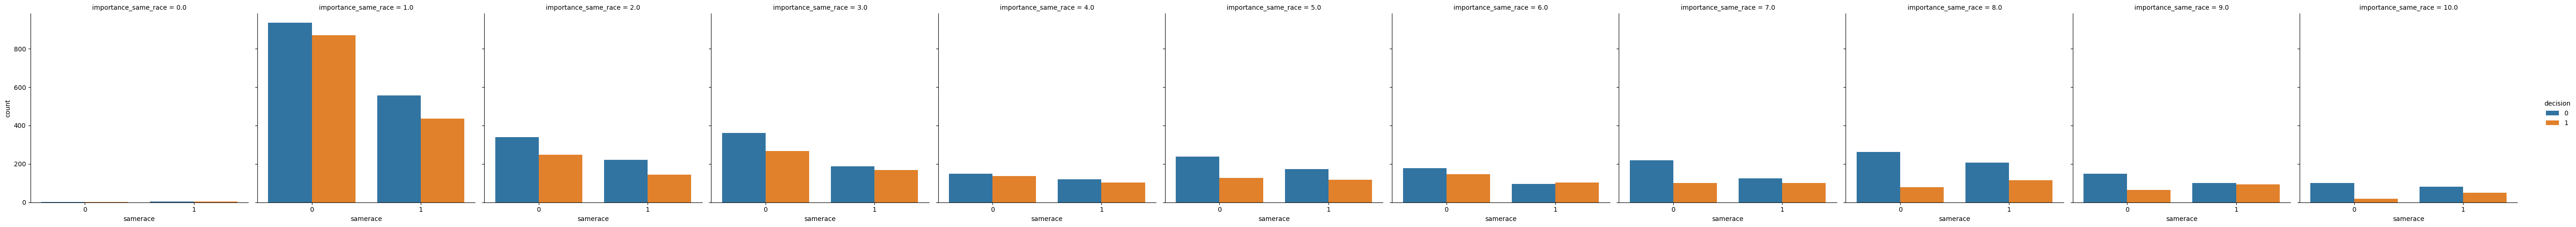

In [8]:
# plot samerace x importance_same_race x match

sns.catplot(x='samerace', hue='decision', col='importance_same_race', data=df, kind='count')

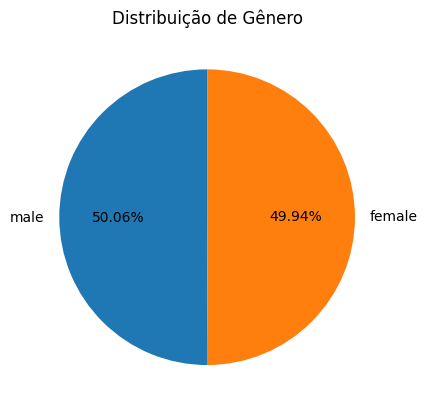

In [9]:
# Contar a distribuição de ambos os gêneros
pie_data = df['gender'].value_counts()  # Conta automaticamente 'male' e 'female'

# Criar o gráfico de pizza
fig, ax = plt.subplots()
ax.pie(
    pie_data,                          # Valores numéricos (contagens)
    labels=pie_data.index,             # Rótulos extraídos dos índices ('male', 'female')
    autopct='%.2f%%',                  # Formato correto: 2 casas decimais
    startangle=90                      # Opcional: ajusta a rotação do gráfico
)
ax.set(title='Distribuição de Gênero')
plt.show()

Esse gráfico demonstra o equilíbrio que há no dataset em relação aos gêneros dos participantes, mas vale ressaltar que nos dias hoje estaria bastante enviesado, visto que é computado apenas relações heterossexuais.

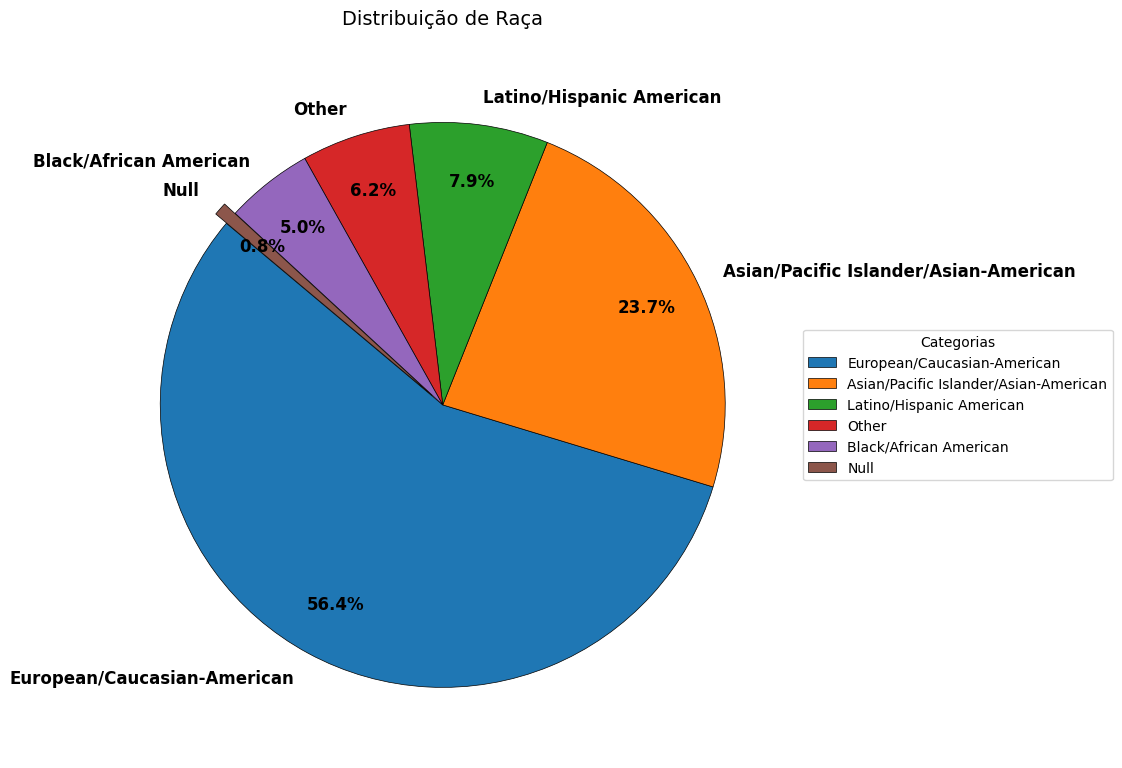

In [10]:
import matplotlib.pyplot as plt

# Contar a distribuição de raças, incluindo valores nulos
pie_data = df['race'].value_counts(dropna=False)  # Inclui NaN

# Renomear NaN para "Null" no índice
pie_data.index = pie_data.index.fillna('Null')

# Calcular a porcentagem de cada categoria
total = pie_data.sum()
threshold_percent = 5  # Define o limite para agrupamento

# Filtrar categorias com >=5% e agrupar as demais em "Null"
filtered_data = pie_data[pie_data / total * 100 >= threshold_percent].copy()
other_sum = pie_data[pie_data / total * 100 < threshold_percent].sum()

if other_sum > 0:
    filtered_data['Null'] = other_sum  # Agrupa em "Null"

# Configurações visuais
plt.figure(figsize=(10, 8))
explode = [0.05 if label == 'Null' else 0 for label in filtered_data.index]  # Destacar "Null"

# Criar o gráfico
wedges, texts, autotexts = plt.pie(
    filtered_data,
    labels=filtered_data.index,
    autopct='%.1f%%',
    startangle=140,  # Ângulo ajustado para melhor distribuição
    explode=explode,
    pctdistance=0.8,
    textprops={'fontsize': 12, 'color': 'black', 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1
)

# Ajustar título e legenda
plt.title('Distribuição de Raça', fontsize=14, pad=20)
plt.legend(
    wedges,
    filtered_data.index,
    title="Categorias",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.tight_layout()
plt.show()

No artigo, os pesquisadores afirmam que o percentual das raças dos participantes do experimento estava de acordo com a população de Manhattan. Porém, quando comparado ao censo de Nova Iorque de 2010, percebe-se que a população negra está subrepresentada e a população branca está superrepresentada.

In [13]:
categoric_cols = df.select_dtypes(include='category').columns
categoric_cols

Index(['has_null', 'gender', 'd_d_age', 'race', 'race_o', 'samerace',
       'd_importance_same_race', 'd_importance_same_religion', 'field',
       'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence',
       'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests',
       'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o',
       'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important',
       'd_sincere_important', 'd_intellicence_important', 'd_funny_important',
       'd_ambtition_important', 'd_shared_interests_important', 'd_attractive',
       'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition',
       'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner',
       'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner',
       'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums',
       'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv',
       'd_theater', 'd_movies', 'd_c

In [27]:
colunas_para_remover = ['has_null', 'gender', 'race', 'race_o'] 
categoric_cols = categoric_cols.difference(colunas_para_remover)
categoric_cols

Index(['d_ambition', 'd_ambition_partner', 'd_ambitous_o',
       'd_ambtition_important', 'd_art', 'd_attractive',
       'd_attractive_important', 'd_attractive_o', 'd_attractive_partner',
       'd_clubbing', 'd_concerts', 'd_d_age', 'd_dining', 'd_exercise',
       'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me',
       'd_expected_num_matches', 'd_funny', 'd_funny_important', 'd_funny_o',
       'd_funny_partner', 'd_gaming', 'd_guess_prob_liked', 'd_hiking',
       'd_importance_same_race', 'd_importance_same_religion',
       'd_intellicence_important', 'd_intelligence', 'd_intelligence_o',
       'd_intelligence_partner', 'd_interests_correlate', 'd_like', 'd_movies',
       'd_museums', 'd_music', 'd_pref_o_ambitious', 'd_pref_o_attractive',
       'd_pref_o_funny', 'd_pref_o_intelligence', 'd_pref_o_shared_interests',
       'd_pref_o_sincere', 'd_reading', 'd_shared_interests_important',
       'd_shared_interests_o', 'd_shared_interests_partner', 'd_sho

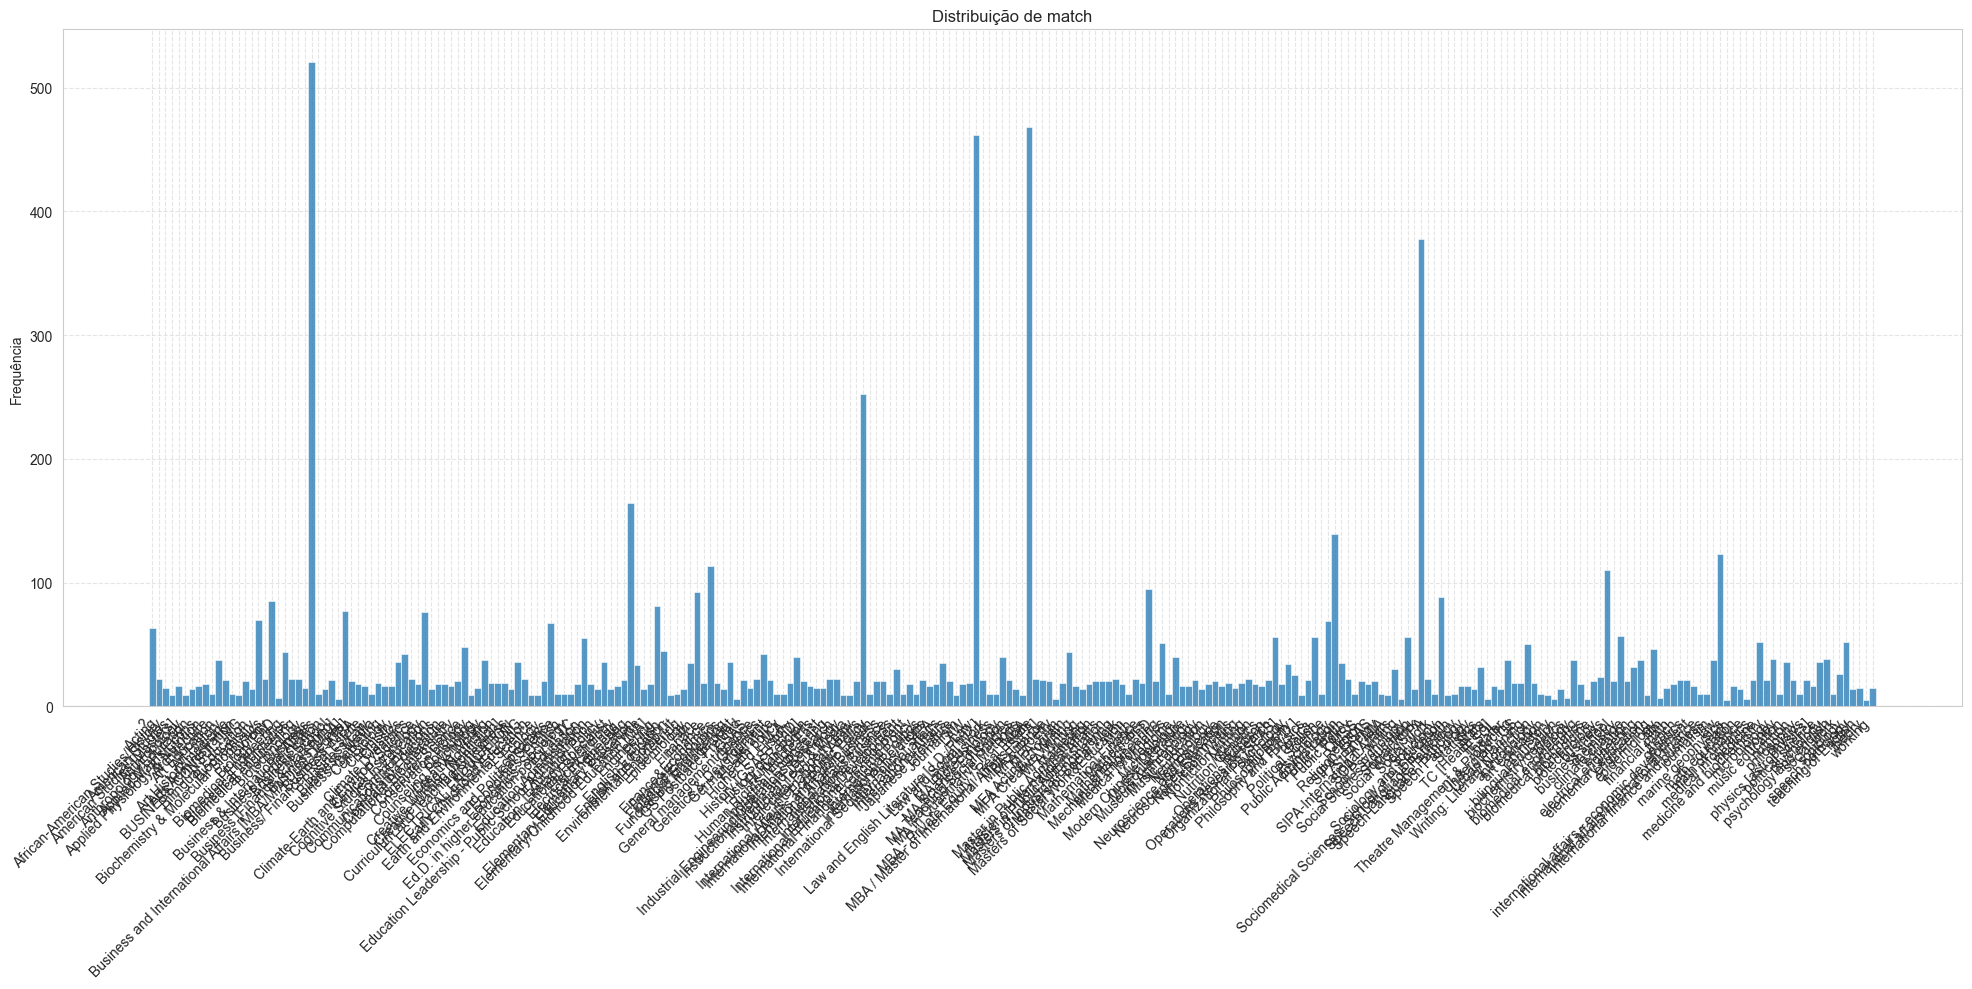

In [25]:
plt.figure(figsize=(20, 10))  # Aumentar o tamanho do gráfico
sns.histplot(df['field'], bins=50)  # Reduzir o número de bins para melhorar a visualização

# Ajustar rótulos
plt.title(f'Distribuição de {col}', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('')
plt.ylabel('Frequência')  # Adicionar rótulo do eixo Y
plt.grid(True, linestyle='--', alpha=0.5)  # Adicionar grid para facilitar a leitura

plt.tight_layout()
plt.show()

C:\Users\caiop\AppData\Local\Temp\ipykernel_6428\3822044322.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
C:\Users\caiop\AppData\Local\Temp\ipykernel_6428\3822044322.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
C:\Users\caiop\AppData\Local\Temp\ipykernel_6428\3822044322.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\caiop\AppData\Local\Temp\ipykernel_6428\3822044322.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.co

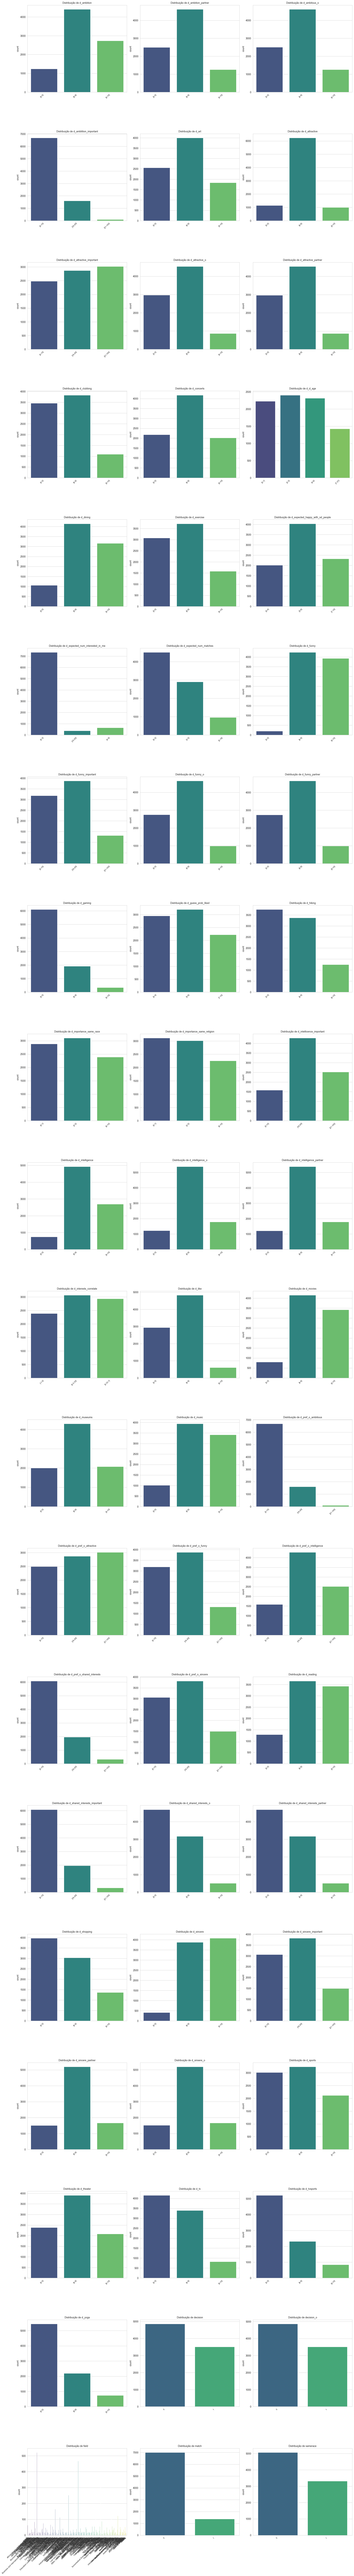

In [28]:
# Configurar a figura
plt.figure(figsize=(20, 150))
sns.set_style("whitegrid")

# Loop para plotar cada coluna
for i, col in enumerate(categoric_cols, 1):
    plt.subplot(len(categoric_cols)//3 + 1, 3, i)  # Organiza em 3 colunas
    
    # Plotar gráfico de barras
    sns.countplot(data=df, x=col, palette="viridis")
    
    # Ajustar rótulos
    plt.title(f'Distribuição de {col}', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.xlabel('')
    plt.tight_layout()

plt.show()